# Exploratory Data Analysis over weather and Patient Diagnoses

## Initialize notebook

In [1]:
import pandas as pd
import os
import duckdb   

from dotenv import load_dotenv, find_dotenv
load_dotenv('/workspaces/patient_conditions_weather/src/.env')
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/workspaces/patient_conditions_weather/airflow/credentials/google_credentials.json'

### Load EMR Records

Currently loading from the RAW stage and doing quick analytics features

In [2]:
emr_path = f"gs://{os.getenv('EMR_RAW_BUCKET')}/{os.getenv('EMR_RAW_PATH')}"
encounters_path = emr_path +'/encounters.csv'
organizations_path = emr_path + '/organizations.csv'
conditions_path = emr_path + '/conditions.csv'

encounters = pd.read_csv(encounters_path, delimiter=",")
conditions = pd.read_csv(conditions_path, delimiter=",")
organizations = pd.read_csv(organizations_path, delimiter=",")


### Condition Type

Dataset displays different type of `conditions` based on `encounters`
For the sake of analysis `diagnoses`, I'm filtering the first 2

|  Conditions Example | (new) Condition Type | 
| --- | --- |
| **Laceration of thigh** | |
| **Streptococcal sore throat (disorder)**| disorder| 
| Severe anxiety (panic) (finding | finding |
| Refugee (person) | person | 
| History of cardiac arrest (situation)| situation |  

For better filtering, creating `condition_type`

In [3]:

import re
rexp = r'\((.*?)\)'
conditions['condition_name'] = conditions['DESCRIPTION'].apply(lambda x: re.sub(r' \([^)]*\)', '', x))
conditions['condition_type'] = conditions['DESCRIPTION'].apply(lambda x: re.search(rexp, x).group(1) if re.search(rexp, x) else '')


In [4]:
# Create a DuckDB connection
con = duckdb.connect()
con.register('encounters', encounters)
con.register('conditions', conditions)
con.register('organizations', organizations)


### Load Daily Weather



In [5]:
weather_daily_data_path = f"gs://{os.getenv('WEATHER_BUCKET')}/{os.getenv('WEATHER_DATA_DAILY_PATH')}"
weather_daily_data = pd.read_parquet(weather_daily_data_path, engine="pyarrow")
con.register('weather_daily_data', weather_daily_data)

## Create table `diagnoses`

Using `condition_type in ('disorder', '')` filter

In [6]:
starting_year = 1980
query = f"""
with events as (
    select 
        CAST(e.stop AS DATE) diagnosis_date,        
        o.name organization_name, o.city organization_city, O.state organization_state,
        round(o.LAT,1) as latitude,
        round(o.LON,1) as longitude,
        c.code,
        c.condition_name,
        c.condition_type        
    from encounters e
    inner join organizations o on e.ORGANIZATION = o.id
    inner join conditions c on e.id = c.ENCOUNTER
)
select *
from events
where extract('year' from diagnosis_date) >= {starting_year}
and condition_type in ('disorder', '')
order by 1
"""
diagnoses = con.execute(query).fetchdf()
con.register('diagnoses', diagnoses)
diagnoses

,diagnosis_date,organization_name,organization_city,organization_state,latitude,longitude,CODE,condition_name,condition_type
0,1980-01-05,BERKSHIRE MEDICAL CENTER INC - 1,PITTSFIELD,MA,42.5,-73.3,230690007,Stroke,
1,1980-01-08,CONCENTRA URGENT CARE - SPRINGFIELD,SPRINGFIELD,MA,42.1,-72.5,53741008,Coronary Heart Disease,
2,1980-01-09,NORWOOD HOSPITAL,NORWOOD,MA,42.2,-71.2,91302008,Sepsis,disorder
3,1980-01-25,FCP INC,LAWRENCE,MA,42.7,-71.2,59621000,Hypertension,
4,1980-02-03,SIGNATURE HEALTHCARE BROCKTON HOSPITAL,BROCKTON,MA,42.1,-71.0,84757009,Epilepsy,
...,...,...,...,...,...,...,...,...,...
7263,2021-11-13,HOLYOKE MEDICAL CENTER,HOLYOKE,MA,42.2,-72.6,72892002,Normal pregnancy,
7264,2021-11-13,Edith Nourse Rogers Memorial Veterans Hospital...,Bedford,MA,42.5,-71.3,43878008,Streptococcal sore throat,disorder
7265,2021-11-14,BRIGHAM AND WOMEN'S FAULKNER HOSPITAL,BOSTON,MA,42.3,-71.0,62106007,Concussion with no loss of consciousness,
7266,2021-11-15,CAREWELL URGENT CARE CENTERS OF MA PC,LEXINGTON,MA,42.4,-71.2,59621000,Hypertension,


## Troubleshoot

### Troubleshoot: Encounters with weather data

In [187]:
query = """
with weather as (
    select 
        distinct
        cast(date as date) as weather_date,
        weather_code,
        temperature_2m_mean,	apparent_temperature_mean,	daylight_duration,	sunshine_duration,	latitude,	longitude
    from weather_daily_data     
)
select 
    d.organization_name,
    d.organization_city,
    d.organization_state,
    d.latitude, d.longitude,
    d.diagnosis_date,
    d.code,
    d.condition_name,
    d.condition_type,
    w.weather_code,
    w.daylight_duration,
    w.sunshine_duration,
    w.apparent_temperature_mean    
from diagnoses d 
inner join weather w on 
    w.latitude = d.latitude
    and w.longitude = d.longitude 
    and w.weather_date = d.diagnosis_date
order by diagnosis_date desc
"""
diagnoses_with_weather = con.execute(query).fetchdf()

diagnoses_with_weather

,organization_name,organization_city,organization_state,latitude,longitude,diagnosis_date,CODE,condition_name,condition_type,weather_code,daylight_duration,sunshine_duration,apparent_temperature_mean
0,BOSTON MEDICAL CENTER CORPORATION-,BOSTON,MA,42.3,-71.0,2021-11-15,72892002,Normal pregnancy,,53,35239.03,31561.48,2.9
1,CAREWELL URGENT CARE CENTERS OF MA PC,LEXINGTON,MA,42.4,-71.2,2021-11-15,59621000,Hypertension,,53,35196.95,31508.69,2.1
2,BRIGHAM AND WOMEN'S FAULKNER HOSPITAL,BOSTON,MA,42.3,-71.0,2021-11-14,62106007,Concussion with no loss of consciousness,,51,35368.93,21345.22,2.1
3,LAHEY HOSPITAL & MEDICAL CENTER BURLINGTON,BURLINGTON,MA,42.5,-71.2,2021-11-13,70704007,Sprain of wrist,,63,35439.89,31769.47,5.9
4,Edith Nourse Rogers Memorial Veterans Hospital...,Bedford,MA,42.5,-71.3,2021-11-13,43878008,Streptococcal sore throat,disorder,63,35439.89,31769.47,6.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4894,SIGNATURE HEALTHCARE BROCKTON HOSPITAL,BROCKTON,MA,42.1,-71.0,1980-02-03,84757009,Epilepsy,,0,36251.24,32736.95,-15.6
4895,FCP INC,LAWRENCE,MA,42.7,-71.2,1980-01-25,59621000,Hypertension,,0,34856.93,31184.84,-14.5
4896,NORWOOD HOSPITAL,NORWOOD,MA,42.2,-71.2,1980-01-09,91302008,Sepsis,disorder,71,33406.16,5660.58,-7.4
4897,CONCENTRA URGENT CARE - SPRINGFIELD,SPRINGFIELD,MA,42.1,-72.5,1980-01-08,53741008,Coronary Heart Disease,,3,33385.33,29013.41,-5.0


### Troubleshoot: Encounters without weather data

As the weather fetching mechanism may have errored or timed out

In [186]:
query = """

with weather as (
    select 
        distinct
        cast(date as date) as weather_date,
        weather_code,
        temperature_2m_mean,	apparent_temperature_mean,	daylight_duration,	sunshine_duration,	latitude,	longitude
    from weather_daily_data     
),
diagnoses_missing_weather  as  (
    select 
        d.diagnosis_date,
        d.code,
        d.condition_name,
        d.condition_type,
        weather_code,
        w.daylight_duration,
        w.sunshine_duration,
        w.apparent_temperature_mean ,
        d.latitude, d.longitude
    from diagnoses d 
    left join weather w on 
        w.latitude = d.latitude
        and w.longitude = d.longitude 
        and w.weather_date = d.diagnosis_date
    where w.weather_date is null    
    order by diagnosis_date desc
)
select distinct 
extract('year' from diagnosis_date) as year,
 latitude, longitude 
from diagnoses_missing_weather
"""
diagnoses_without_weather = con.execute(query).fetchdf()

diagnoses_without_weather

,year,latitude,longitude
0,2013,42.5,-71.1
1,2013,42.5,-71.2
2,2013,42.3,-71.2
3,2013,42.3,-71.5
4,2013,42.3,-71.1
...,...,...,...
619,1987,42.2,-71.5
620,1987,42.2,-71.3
621,1986,42.3,-71.8
622,1986,42.5,-71.0


In [9]:
#diagnoses_with_weather['apparent_temperature_mean_q_bins'] = pd.qcut(diagnoses_with_weather['apparent_temperature_mean'], q=6)
diagnoses_with_weather['apparent_temperature_mean_bins'] = pd.cut(diagnoses_with_weather['apparent_temperature_mean'], bins=6, labels=None)
diagnoses_with_weather['apparent_temperature_mean_bins_str'] = diagnoses_with_weather['apparent_temperature_mean_bins'].astype(str)
diagnoses_with_weather['apparent_temperature_mean_bin_lower_bound'] = pd.IntervalIndex(diagnoses_with_weather['apparent_temperature_mean_bins']).left
diagnoses_with_weather = diagnoses_with_weather.drop('apparent_temperature_mean_bins', axis=1)
diagnoses_with_weather

,organization_name,organization_city,organization_state,latitude,longitude,diagnosis_date,CODE,condition_name,condition_type,daylight_duration,sunshine_duration,apparent_temperature_mean,apparent_temperature_mean_bins_str,apparent_temperature_mean_bin_lower_bound
0,CAREWELL URGENT CARE CENTERS OF MA PC,LEXINGTON,MA,42.4,-71.2,2021-11-15,59621000,Hypertension,,35196.95,31508.69,2.1,"(-6.667, 3.35]",-6.667
1,BOSTON MEDICAL CENTER CORPORATION-,BOSTON,MA,42.3,-71.0,2021-11-15,72892002,Normal pregnancy,,35239.03,31561.48,2.9,"(-6.667, 3.35]",-6.667
2,BRIGHAM AND WOMEN'S FAULKNER HOSPITAL,BOSTON,MA,42.3,-71.0,2021-11-14,62106007,Concussion with no loss of consciousness,,35368.93,21345.22,2.1,"(-6.667, 3.35]",-6.667
3,HOLYOKE MEDICAL CENTER,HOLYOKE,MA,42.2,-72.6,2021-11-13,72892002,Normal pregnancy,,35521.24,24814.77,5.3,"(3.35, 13.367]",3.350
4,ST VINCENT HOSPITAL,WORCESTER,MA,42.3,-71.8,2021-11-13,72892002,Normal pregnancy,,35500.97,28436.78,5.9,"(3.35, 13.367]",3.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4894,SIGNATURE HEALTHCARE BROCKTON HOSPITAL,BROCKTON,MA,42.1,-71.0,1980-02-03,84757009,Epilepsy,,36251.24,32736.95,-15.6,"(-16.683, -6.667]",-16.683
4895,FCP INC,LAWRENCE,MA,42.7,-71.2,1980-01-25,59621000,Hypertension,,34856.93,31184.84,-14.5,"(-16.683, -6.667]",-16.683
4896,NORWOOD HOSPITAL,NORWOOD,MA,42.2,-71.2,1980-01-09,91302008,Sepsis,disorder,33406.16,5660.58,-7.4,"(-16.683, -6.667]",-16.683
4897,CONCENTRA URGENT CARE - SPRINGFIELD,SPRINGFIELD,MA,42.1,-72.5,1980-01-08,53741008,Coronary Heart Disease,,33385.33,29013.41,-5.0,"(-6.667, 3.35]",-6.667


In [10]:
diagnoses_with_weather.dtypes

organization_name                                    object
organization_city                                    object
organization_state                                   object
latitude                                            float64
longitude                                           float64
diagnosis_date                               datetime64[us]
CODE                                                  int64
condition_name                                       object
condition_type                                       object
daylight_duration                                   float64
sunshine_duration                                   float64
apparent_temperature_mean                           float64
apparent_temperature_mean_bins_str                   object
apparent_temperature_mean_bin_lower_bound           float64
dtype: object

In [11]:
con.register('diagnoses_with_weather', diagnoses_with_weather)

## Dataset Description

### Weather Dataset
Based on Encounter events

In [188]:
weather_daily_data.describe()

,weather_code,temperature_2m_mean,apparent_temperature_mean,daylight_duration,sunshine_duration
count,1.469131e+06,1.469131e+06,1.469131e+06,1.469131e+06,1.469131e+06
mean,2.995449e+01,9.849432e+00,7.441508e+00,4.396138e+04,2.949237e+04
std,2.921049e+01,9.571614e+00,1.193224e+01,7.626063e+03,1.524866e+04
min,0.000000e+00,-2.520000e+01,-3.220000e+01,3.243421e+04,0.000000e+00
25%,3.000000e+00,2.400000e+00,-2.000000e+00,3.658074e+04,2.077444e+04
50%,3.000000e+00,1.010000e+01,7.200000e+00,4.406096e+04,3.222944e+04
75%,6.100000e+01,1.820000e+01,1.780000e+01,5.136251e+04,4.173518e+04
max,7.500000e+01,3.280000e+01,3.470000e+01,5.526755e+04,5.122112e+04


In [189]:
weather_daily_data.head(10)

,date,weather_code,temperature_2m_mean,apparent_temperature_mean,daylight_duration,sunshine_duration,frequency,year,latitude,longitude
0,1979-01-01 00:00:00+00:00,51,7.9,3.4,33198.72,1251.11,daily,1979,41.6,-70.5
1,1979-01-02 00:00:00+00:00,61,11.9,7.1,33243.27,1247.72,daily,1979,41.6,-70.5
2,1979-01-03 00:00:00+00:00,63,4.6,-1.0,33291.53,28647.03,daily,1979,41.6,-70.5
3,1979-01-04 00:00:00+00:00,3,-4.4,-10.5,33343.43,24297.17,daily,1979,41.6,-70.5
4,1979-01-05 00:00:00+00:00,3,-3.3,-8.9,33398.93,29351.38,daily,1979,41.6,-70.5
5,1979-01-06 00:00:00+00:00,73,-1.1,-5.0,33457.93,1460.15,daily,1979,41.6,-70.5
6,1979-01-07 00:00:00+00:00,71,2.1,-1.5,33520.39,338.78,daily,1979,41.6,-70.5
7,1979-01-08 00:00:00+00:00,63,9.0,4.7,33586.23,0.00,daily,1979,41.6,-70.5
8,1979-01-09 00:00:00+00:00,71,-0.7,-5.7,33655.53,29713.32,daily,1979,41.6,-70.5
9,1979-01-10 00:00:00+00:00,3,-2.9,-8.3,33729.07,29975.97,daily,1979,41.6,-70.5


### Weather Data Descriptive Statistics

In [190]:
desc = diagnoses_with_weather[['daylight_duration', 'sunshine_duration', 'apparent_temperature_mean', 'weather_code']].describe().T

# Add the "Units" column
desc['Units'] = ['seconds', 'seconds', 'Celsius °C', 'WMO']

desc

#diagnoses_with_weather[['daylight_duration', 'sunshine_duration', 'apparent_temperature_mean']].describe().T.add('Units', ['seconds', 'seconds', 'Celsius °C'])


,count,mean,std,min,25%,50%,75%,max,Units
daylight_duration,4899.0,43821.538606,7548.477305,32498.62,36566.72,43675.27,51074.205,55187.19,seconds
sunshine_duration,4899.0,29272.101443,15128.155948,0.00,21408.52,31849.81,41034.580,50863.21,seconds
apparent_temperature_mean,4899.0,7.635048,12.148923,-26.70,-2.30,7.10,18.100,33.40,Celsius °C
weather_code,4899.0,30.474587,29.226938,0.00,3.00,3.00,61.000,75.00,WMO


### Diagnoses Description

In [192]:
# Get top 2 most common conditions
top_conditions = diagnoses_with_weather['condition_name'].value_counts().nlargest(2)

# Get top 2 most common locations (latitude, longitude)
location_columns = ['organization_name', 'organization_city', 'organization_state']
top_locations = diagnoses_with_weather.groupby(location_columns).size().nlargest(2)

# Create summary table
summary = pd.DataFrame({
    "Total Records": [len(diagnoses_with_weather)],
    "Unique Locations": [diagnoses_with_weather[location_columns].drop_duplicates().shape[0]],
    "Min Diagnosis Date": [diagnoses_with_weather['diagnosis_date'].min()],
    "Max Diagnosis Date": [diagnoses_with_weather['diagnosis_date'].max()],
    "Unique Conditions": [diagnoses_with_weather['condition_name'].nunique()],
    "Top 1 Condition": [top_conditions.index[0] if len(top_conditions) > 0 else None],
    "Top 1 Condition Count": [top_conditions.iloc[0] if len(top_conditions) > 0 else None],
    "Top 2 Condition": [top_conditions.index[1] if len(top_conditions) > 1 else None],
    "Top 2 Condition Count": [top_conditions.iloc[1] if len(top_conditions) > 1 else None],
    "Top 1 Location": [(top_locations.index[0] if len(top_locations) > 0 else None)],
    "Top 1 Location Count": [top_locations.iloc[0] if len(top_locations) > 0 else None],
    "Top 2 Location": [(top_locations.index[1] if len(top_locations) > 1 else None)],
    "Top 2 Location Count": [top_locations.iloc[1] if len(top_locations) > 1 else None],
})

summary.T



,0
Total Records,4899
Unique Locations,408
Min Diagnosis Date,1980-01-05 00:00:00
Max Diagnosis Date,2021-11-15 00:00:00
Unique Conditions,139
Top 1 Condition,Viral sinusitis
Top 1 Condition Count,847
Top 2 Condition,Acute viral pharyngitis
Top 2 Condition Count,484
Top 1 Location,"(FALMOUTH HOSPITAL, FALMOUTH, MA)"


In [202]:

# Create summary table
summary = pd.DataFrame({
    "Total Records": [len(diagnoses_with_weather)],
    "Min Diagnosis Date": [diagnoses_with_weather['diagnosis_date'].min()],
    "Max Diagnosis Date": [diagnoses_with_weather['diagnosis_date'].max()],
    "Unique Locations": [diagnoses_with_weather[location_columns].drop_duplicates().shape[0]],    
    "Top 1 Location": [(top_locations.index[0], top_locations.iloc[0]) if len(top_locations) > 0 else None],
    "Top 2 Location": [(top_locations.index[1], top_locations.iloc[1]) if len(top_locations) > 1 else None],
    "Unique Conditions": [diagnoses_with_weather['condition_name'].nunique()],

    "Top 1 Condition": [(top_conditions.index[0], top_conditions.iloc[0]) if len(top_conditions) > 0 else None],
    "Top 2 Condition": [(top_conditions.index[1], top_conditions.iloc[1]) if len(top_conditions) > 1 else None]
    
    
})

summary.T



,0
Total Records,4899
Min Diagnosis Date,1980-01-05 00:00:00
Max Diagnosis Date,2021-11-15 00:00:00
Unique Locations,408
Top 1 Location,"((FALMOUTH HOSPITAL, FALMOUTH, MA), 216)"
Top 2 Location,"((LOWELL GENERAL HOSPITAL, LOWELL, MA), 209)"
Unique Conditions,139
Top 1 Condition,"(Viral sinusitis, 847)"
Top 2 Condition,"(Acute viral pharyngitis, 484)"


### Plot function

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt

def barplot(data, sort_by_column, sort_by_ascending, x_column_name, y_column_name, hue, title, xlabel, ylabel, legend_title, horizontal=False, palette=None):
    plt.figure(figsize=(12, 6))
    sorted_data = data.sort_values(by=sort_by_column, ascending=sort_by_ascending)
        
    if hue: 
         # Calculate total counts for each hue category     
        hue_order = data.groupby(hue)[y_column_name].sum().sort_values(ascending=False).index.tolist()

        # Automatically resize palette to match hue categories
        if palette is None:
            palette = sns.color_palette("muted", len(hue_order))
        else:
            palette = palette[:len(hue_order)]  # Ensure palette length matches hue categories

        # Create a color map for the ordered hue
        ordered_palette = {h: palette[i] for i, h in enumerate(hue_order)}
        palette = ordered_palette
    
    # Draw the barplot with the ordered hue
    sns.barplot(
        data=sorted_data,
        x=x_column_name,
        y=y_column_name,
        hue=hue,
        palette=palette,
        orient='h' if horizontal else 'v' 
    )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.legend(title=legend_title)
    plt.xticks(rotation=45)

    # Manually add ordered legend
    handles, labels = plt.gca().get_legend_handles_labels()
    ordered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l in hue_order]
    ordered_handles_labels.sort(key=lambda x: hue_order.index(x[1]))

    plt.legend(
        [h for h, _ in ordered_handles_labels],
        [l for _, l in ordered_handles_labels],
        title=legend_title,
        bbox_to_anchor=(1.05, 1),  # Places legend outside the plot
        loc='upper left'
    )


    plt.tight_layout()
    plt.show()

## Top 10 Diagnoses Overall

In [133]:
query = """
with ranked_conditions as (
    select     
    code,
    condition_name,       
    count(1) as count    
    from diagnoses_with_weather 
    group by code, condition_name,
)
select *
from ranked_conditions
order by  count desc
"""
diagnoses_count_overall = con.execute(query).fetchdf()
diagnoses_count_overall.head(10)

,CODE,condition_name,count
0,444814009,Viral sinusitis,847
1,195662009,Acute viral pharyngitis,484
2,10509002,Acute bronchitis,403
3,72892002,Normal pregnancy,337
4,15777000,Prediabetes,153
5,271737000,Anemia,149
6,65363002,Otitis media,139
7,43878008,Streptococcal sore throat,120
8,59621000,Hypertension,117
9,19169002,Miscarriage in first trimester,97


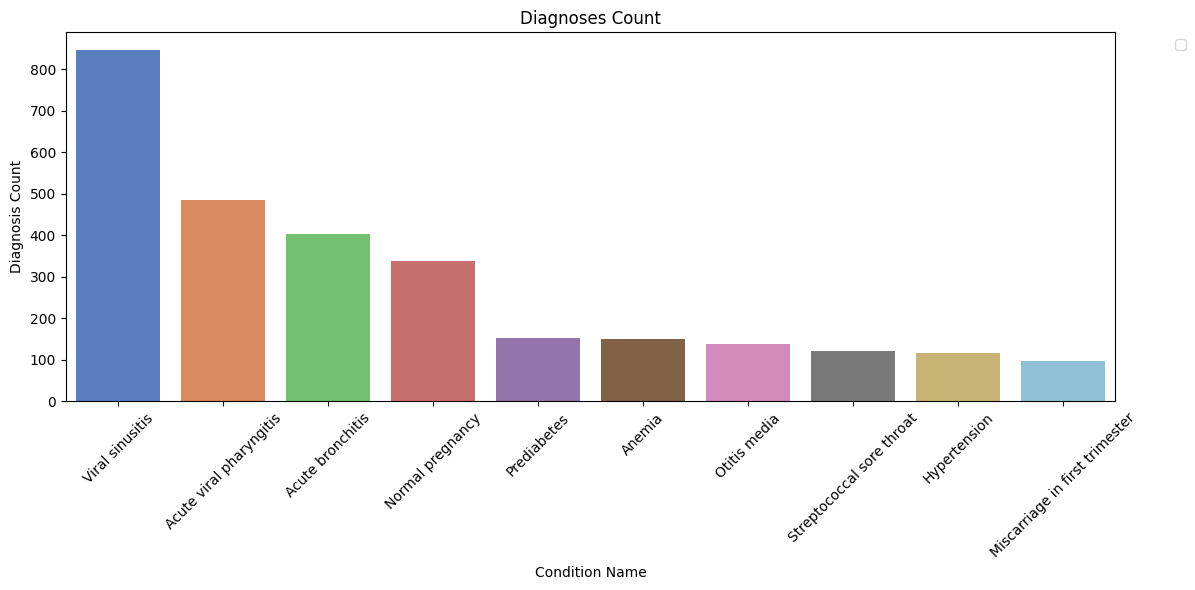

In [164]:
   barplot(
        data=diagnoses_count_overall.head(10),
        sort_by_column='count',
        sort_by_ascending=False,
        x_column_name='condition_name',
        y_column_name='count',
        hue='count',
        title=f"Diagnoses Count",
        xlabel='Condition Name',
        ylabel='Diagnosis Count',
        legend_title=''
    )


## Diagnoses Count By Year

In [131]:
query = f"""
with ranked_conditions as (
    select 
    extract('year' from diagnosis_date) as diagnosis_year,    
    count(1) as count    
    from diagnoses_with_weather 
    group by extract('year' from diagnosis_date)
)
select *
from ranked_conditions
where 1=1
order by diagnosis_year desc
"""
diagnoses_by_year = con.execute(query).fetchdf()
diagnoses_by_year


,diagnosis_year,count
0,2021,543
1,2020,562
2,2019,466
3,2018,495
4,2017,446
5,2016,422
6,2015,198
7,2014,228
8,2013,173
9,2012,187


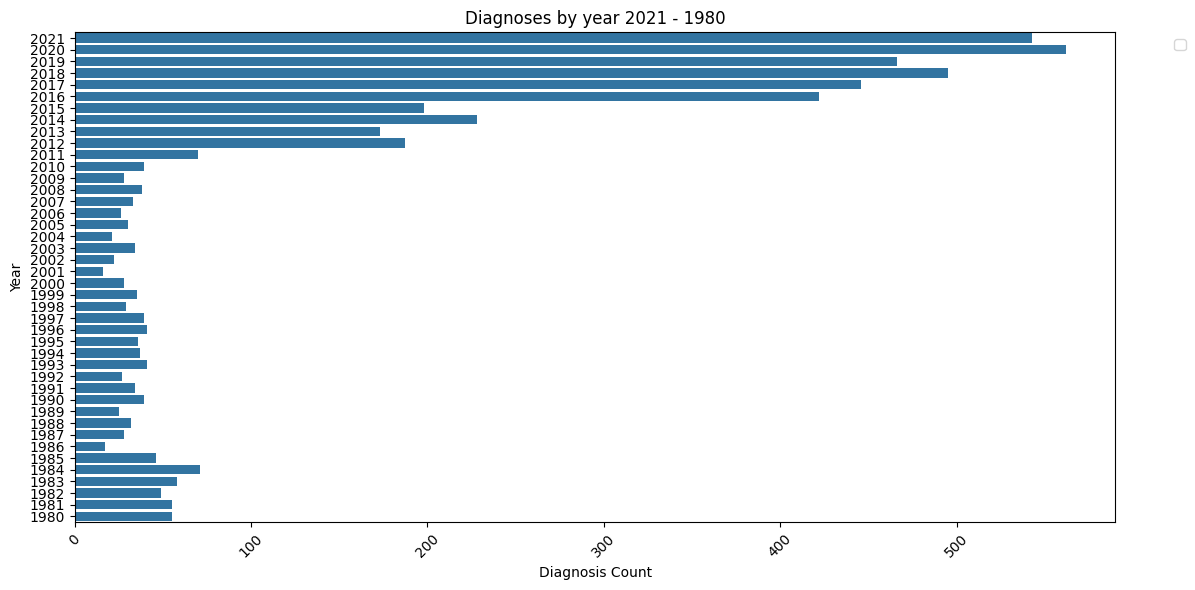

In [162]:
diagnoses_by_year['diagnosis_year'] = pd.Categorical(
    diagnoses_by_year['diagnosis_year'],
    categories=sorted(diagnoses_by_year['diagnosis_year'].unique(), reverse=True),
    ordered=True
)


barplot(
        data=diagnoses_by_year,
        sort_by_column='diagnosis_year',
        sort_by_ascending=False,
        
        x_column_name='count',
        y_column_name='diagnosis_year',
        hue=None,
        title=f"Diagnoses by year {diagnoses_by_year['diagnosis_year'].min()} - {diagnoses_by_year['diagnosis_year'].max()}",
        
        xlabel='Diagnosis Count',
        ylabel='Year',
        legend_title='',
        horizontal=True
    )


In [101]:
start_year_plot = 2012

## Top 3 Diagnoses by Year, since 

In [84]:
start_year_plot

2008

In [102]:
query = f"""
with ranked_conditions as (
    select 
    extract('year' from diagnosis_date) as diagnosis_year,    
    code,
    condition_name,       
    count(1) as count,
    row_number() over (partition by extract('year' from diagnosis_date) order by count(1) desc) as rn
    from diagnoses_with_weather 
    group by extract('year' from diagnosis_date), code, condition_name,
)
select *
from ranked_conditions
where rn <= 3
and diagnosis_year >= {start_year_plot}
order by diagnosis_year desc, rn asc
"""
top_diagnoses_by_year = con.execute(query).fetchdf()
top_diagnoses_by_year


,diagnosis_year,CODE,condition_name,count,rn
0,2021,444814009,Viral sinusitis,95,1
1,2021,72892002,Normal pregnancy,47,2
2,2021,195662009,Acute viral pharyngitis,46,3
3,2020,444814009,Viral sinusitis,103,1
4,2020,195662009,Acute viral pharyngitis,61,2
5,2020,840544004,Suspected COVID-19,52,3
6,2019,444814009,Viral sinusitis,99,1
7,2019,195662009,Acute viral pharyngitis,57,2
8,2019,10509002,Acute bronchitis,51,3
9,2018,444814009,Viral sinusitis,112,1


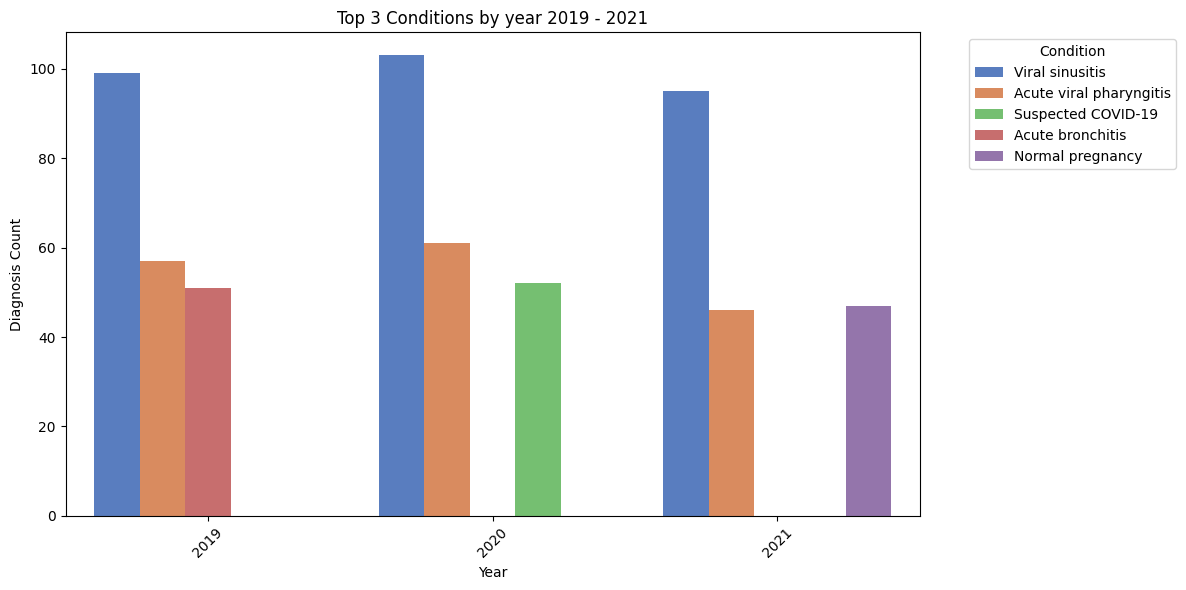

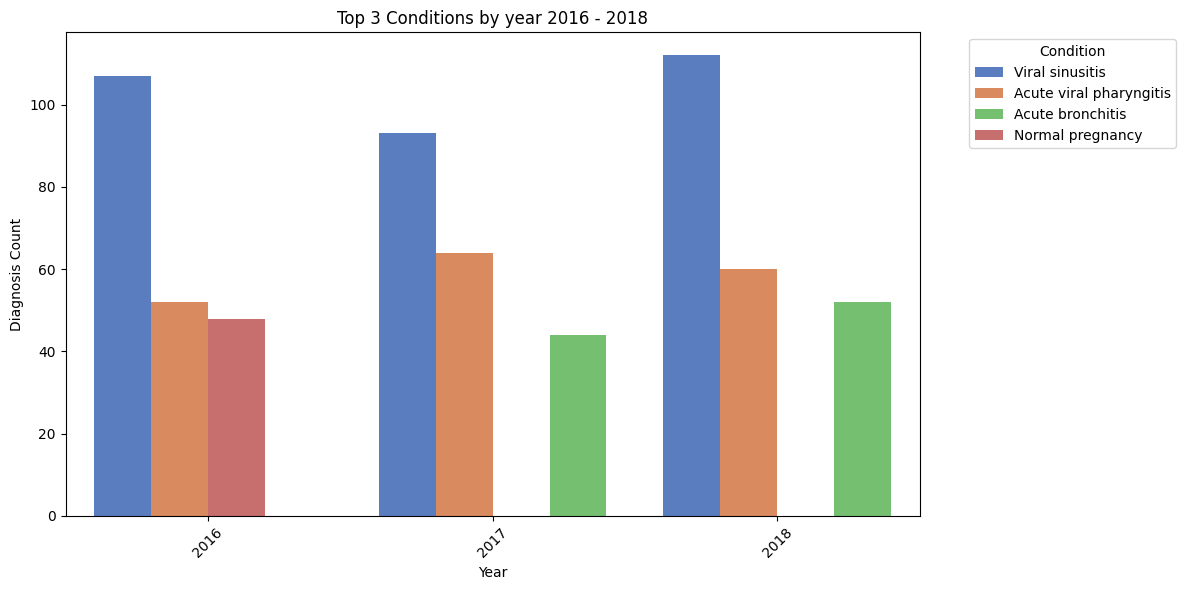

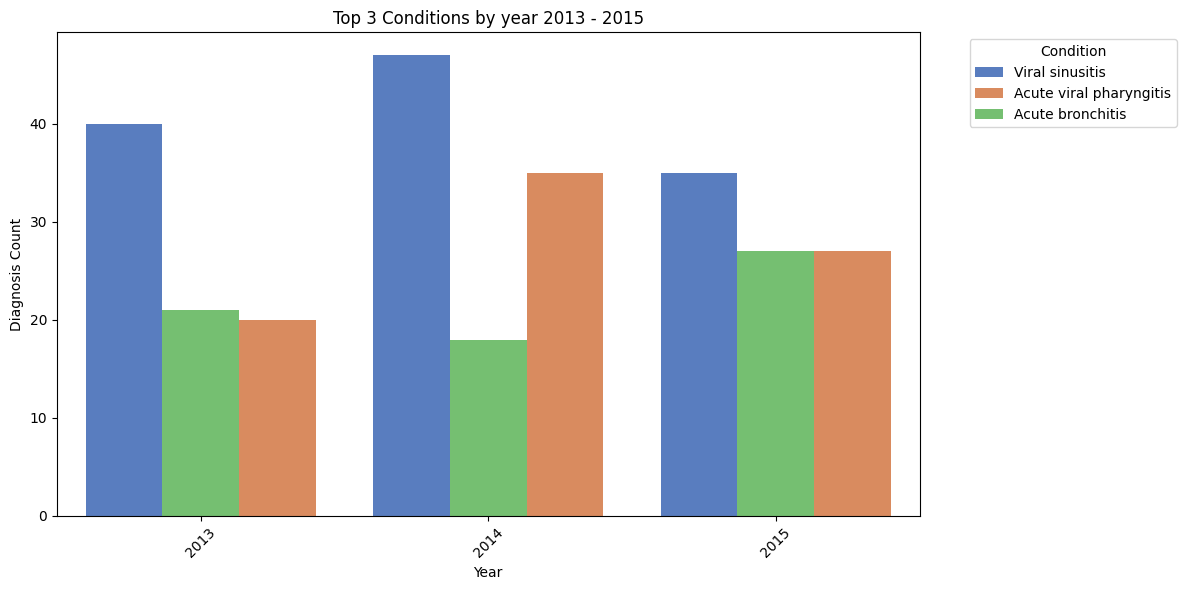

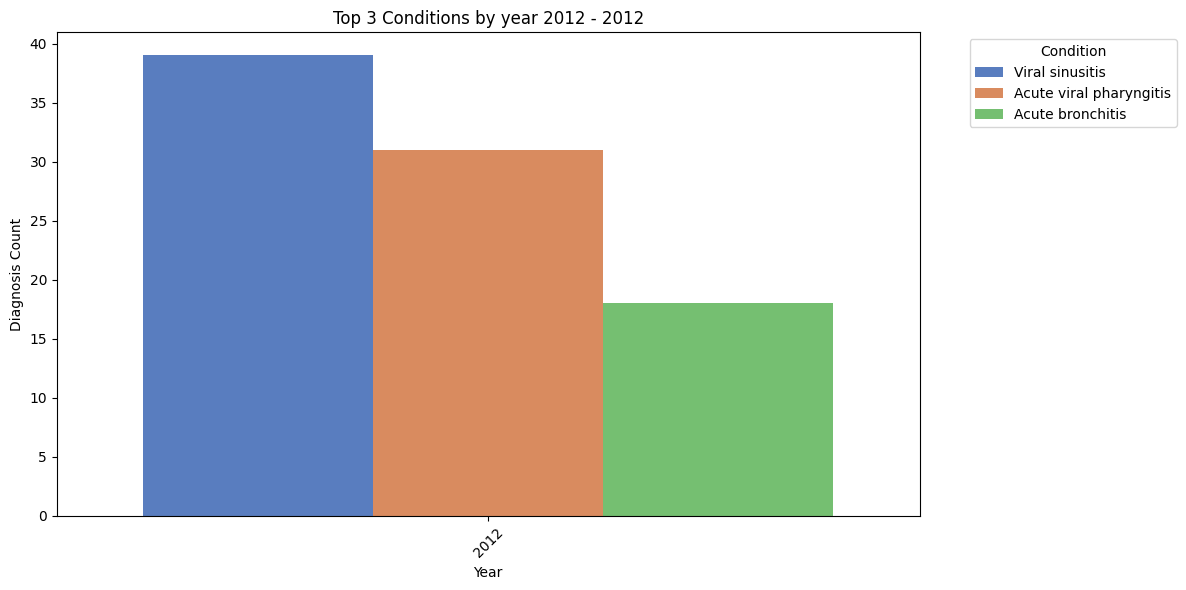

In [165]:

# Get unique years sorted in descending order (from your query order)
unique_years = sorted(top_diagnoses_by_year['diagnosis_year'].unique(), reverse=True)

# Split years into chunks of 3
year_groups = [unique_years[i:i + 3] for i in range(0, len(unique_years), 3)]

# Create a list of DataFrames, each with 3 years of data
dfs_by_3_years = [top_diagnoses_by_year[top_diagnoses_by_year['diagnosis_year'].isin(year_group)] for year_group in year_groups]

# Display summary of split DataFrames
for i, df in enumerate(dfs_by_3_years, start=1):
    #print(f"📊 DataFrame {i}: Years {df['diagnosis_year'].min()} - {df['diagnosis_year'].max()}")
    #display(df)  # Use display() in Jupyter; otherwise, use print(df.head())
    
    barplot(
        data=df,
        sort_by_column='diagnosis_year',
        sort_by_ascending=True,
        x_column_name='diagnosis_year',
        y_column_name='count',
        hue='condition_name',
        title=f"Top 3 Conditions by year {df['diagnosis_year'].min()} - {df['diagnosis_year'].max()}",
        xlabel='Year',
        ylabel='Diagnosis Count',
        legend_title='Condition'
    )


## Top 3 Diagnoses by Temperature Ranges

In [177]:
query = """
with ranked_conditions as (
    select 
    apparent_temperature_mean_bins_str,
    code,
    condition_name,   
    min(apparent_temperature_mean_bin_lower_bound)  as apparent_temperature_mean_bin_lower_bound,
    count(1) as count,
    row_number() over (partition by apparent_temperature_mean_bins_str order by count(1) desc) as rn
    from diagnoses_with_weather 
    group by apparent_temperature_mean_bins_str, code, condition_name,
),
total_counts as (
    select 
        apparent_temperature_mean_bins_str,
        sum(count) as total_count
    from ranked_conditions
    group by apparent_temperature_mean_bins_str
)
select 
    rc.apparent_temperature_mean_bin_lower_bound,
    rc.apparent_temperature_mean_bins_str,    
    rc.code,
    rc.condition_name,
    rc.count,
    round(100.0 * rc.count / tc.total_count, 2) as percentage,
    rn
from ranked_conditions rc
join total_counts tc on rc.apparent_temperature_mean_bins_str = tc.apparent_temperature_mean_bins_str
where rn <= 3
order by apparent_temperature_mean_bin_lower_bound desc, rn asc
"""
diagnosis_by_temp_ranges = con.execute(query).fetchdf()
diagnosis_by_temp_ranges

,apparent_temperature_mean_bin_lower_bound,apparent_temperature_mean_bins_str,CODE,condition_name,count,percentage,rn
0,23.383,"(23.383, 33.4]",444814009,Viral sinusitis,99,17.87,1
1,23.383,"(23.383, 33.4]",195662009,Acute viral pharyngitis,78,14.08,2
2,23.383,"(23.383, 33.4]",10509002,Acute bronchitis,47,8.48,3
3,13.367,"(13.367, 23.383]",444814009,Viral sinusitis,215,17.84,1
4,13.367,"(13.367, 23.383]",10509002,Acute bronchitis,112,9.29,2
5,13.367,"(13.367, 23.383]",195662009,Acute viral pharyngitis,104,8.63,3
6,3.350,"(3.35, 13.367]",444814009,Viral sinusitis,209,18.37,1
7,3.350,"(3.35, 13.367]",195662009,Acute viral pharyngitis,106,9.31,2
8,3.350,"(3.35, 13.367]",10509002,Acute bronchitis,95,8.35,3
9,-6.667,"(-6.667, 3.35]",444814009,Viral sinusitis,241,17.21,1


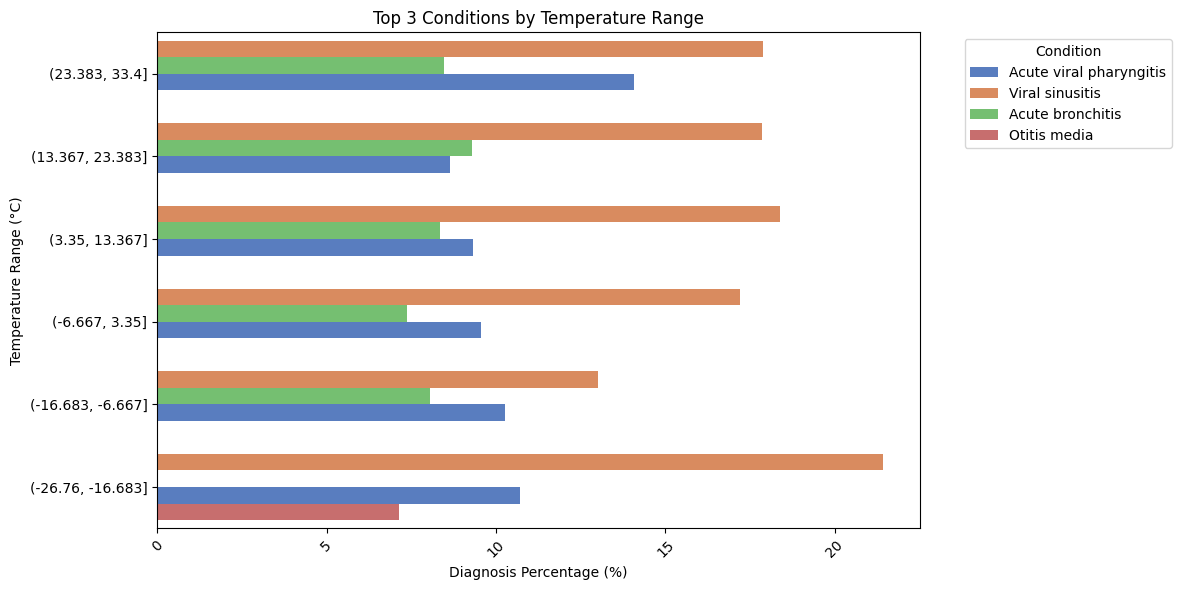

In [181]:


barplot(
    data=diagnosis_by_temp_ranges,
    sort_by_column='apparent_temperature_mean_bin_lower_bound',
    sort_by_ascending=False,
    x_column_name='percentage',
    y_column_name='apparent_temperature_mean_bins_str',    
    hue='condition_name',
    title='Top 3 Conditions by Temperature Range',
    xlabel='Diagnosis Percentage (%)',
    ylabel='Temperature Range (°C)',    
    legend_title='Condition',
    horizontal=True
)
    

## Top 3 Diagnoses by Month

In [123]:
query = """
with ranked_conditions as (
    select 
    extract('month' from diagnosis_date) as diagnosis_month,    
    strftime('%B', diagnosis_date) as diagnosis_month_name,
    code,
    condition_name,       
    count(1) as count,
    row_number() over (partition by extract('month' from diagnosis_date) order by count(1) desc) as rn
    from diagnoses_with_weather 
    group by extract('month' from diagnosis_date), strftime('%B', diagnosis_date) , code, condition_name,
)
select *
from ranked_conditions
where rn <= 3
order by diagnosis_month asc, rn asc
limit 36
"""
top_diagnoses_by_month = con.execute(query).fetchdf()
top_diagnoses_by_month

,diagnosis_month,diagnosis_month_name,CODE,condition_name,count,rn
0,1,January,444814009,Viral sinusitis,89,1
1,1,January,195662009,Acute viral pharyngitis,40,2
2,1,January,10509002,Acute bronchitis,31,3
3,2,February,444814009,Viral sinusitis,57,1
4,2,February,195662009,Acute viral pharyngitis,43,2
5,2,February,10509002,Acute bronchitis,28,3
6,3,March,444814009,Viral sinusitis,77,1
7,3,March,195662009,Acute viral pharyngitis,49,2
8,3,March,10509002,Acute bronchitis,37,3
9,4,April,444814009,Viral sinusitis,74,1


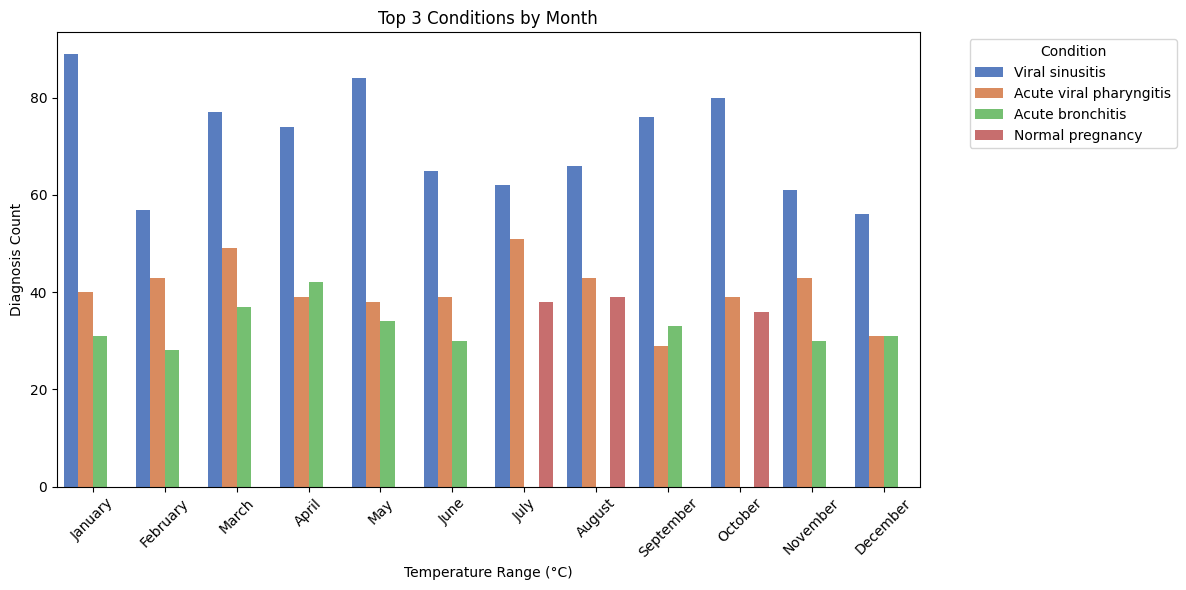

In [183]:


barplot(
    data=top_diagnoses_by_month,
    sort_by_column='diagnosis_month',
    sort_by_ascending=True,
    x_column_name='diagnosis_month_name',
    y_column_name='count',
    hue='condition_name',
    title='Top 3 Conditions by Month',
    xlabel='Temperature Range (°C)',
    ylabel='Diagnosis Count',
    legend_title='Condition'
)
    

## Regression
Is there a correlation (linear) between the sheer amount of diagnoses ? Seems not

In [204]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error



df = diagnoses_with_weather.copy()
df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'])
df_grouped = df.groupby(['apparent_temperature_mean', 'daylight_duration', 'sunshine_duration']).size().reset_index(name='diagnosis_count')

# Normalize columns features (for regression)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_grouped[['apparent_temperature_mean', 'daylight_duration', 'sunshine_duration']] = scaler.fit_transform(df_grouped[['apparent_temperature_mean', 'daylight_duration', 'sunshine_duration']])


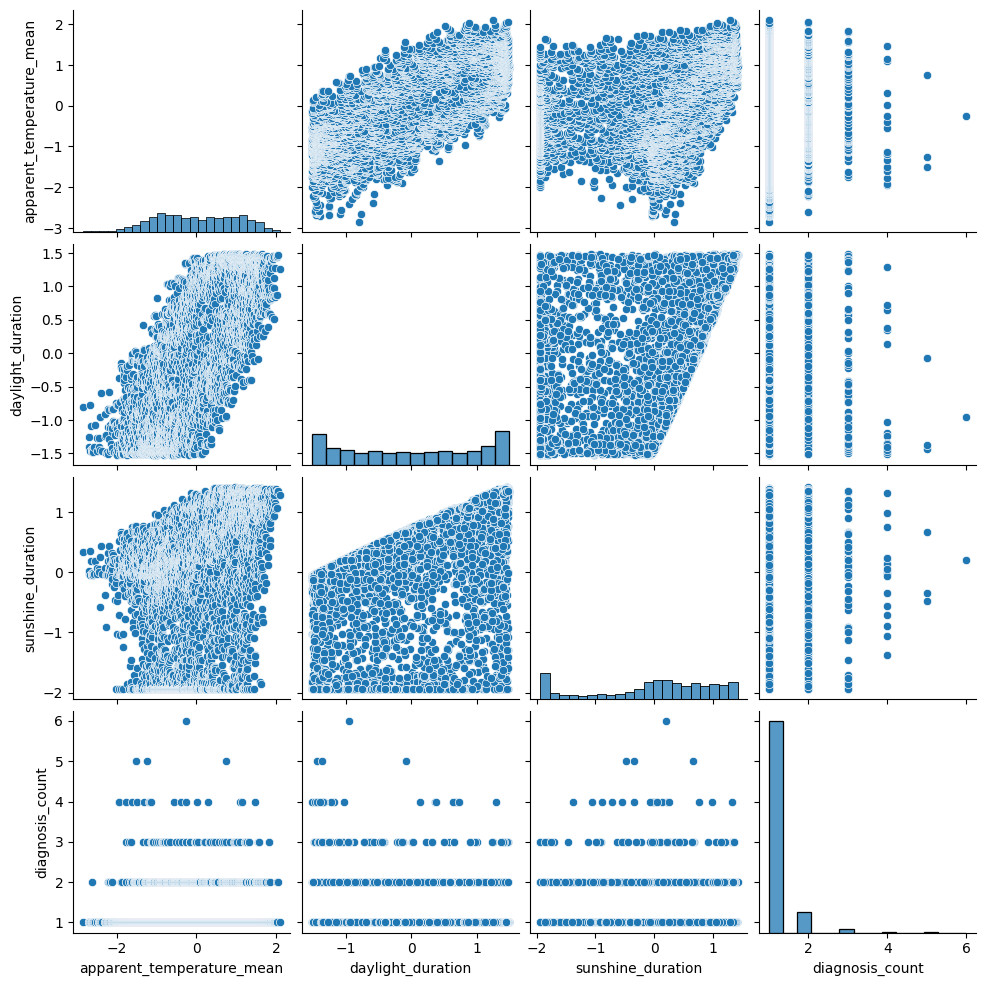

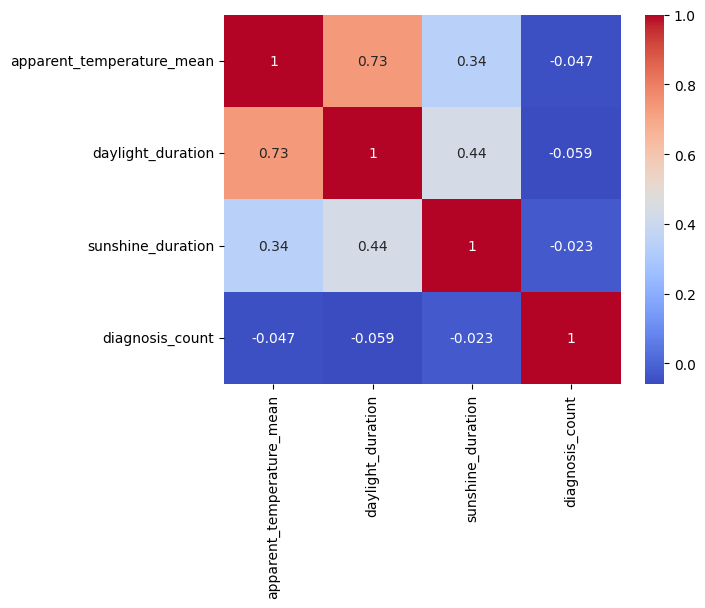

In [205]:
sns.pairplot(df_grouped, vars=['apparent_temperature_mean', 'daylight_duration', 'sunshine_duration', 'diagnosis_count'])
plt.show()
# Correlation Heatmap
sns.heatmap(df_grouped.corr(), annot=True, cmap='coolwarm')
plt.show()


Univariate Regression for apparent_temperature_mean:
R-squared: -0.00048267015343572695
Mean Absolute Error: 0.23682761555524193


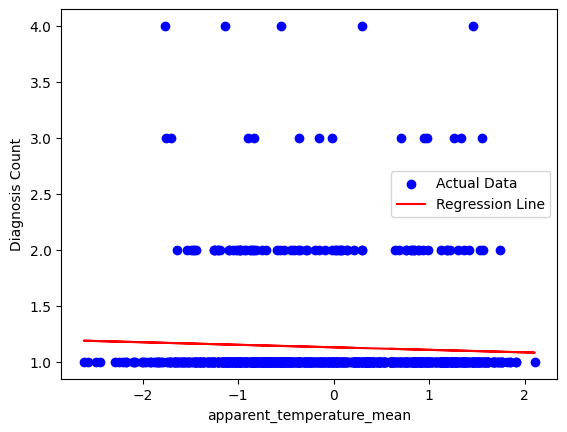

Univariate Regression for daylight_duration:
R-squared: -0.0009643551220497315
Mean Absolute Error: 0.23607900022240164


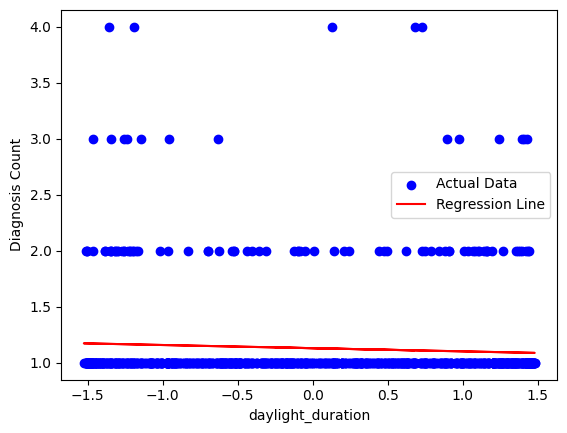

Univariate Regression for sunshine_duration:
R-squared: 0.00011540667960840967
Mean Absolute Error: 0.23583837136012817


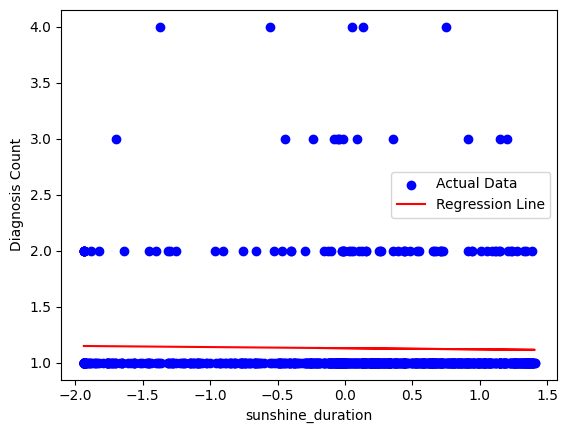

In [206]:
def univariate_regression(feature):
    X = df_grouped[[feature]]
    y = df_grouped['diagnosis_count']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(f"Univariate Regression for {feature}:")
    print("R-squared:", r2_score(y_test, y_pred))
    print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
    
    # Scatter plot
    plt.scatter(X_test, y_test, label="Actual Data", color="blue")
    plt.plot(X_test, y_pred, label="Regression Line", color="red")
    plt.xlabel(feature)
    plt.ylabel("Diagnosis Count")
    plt.legend()
    plt.show()

# Univariate regressions
univariate_regression('apparent_temperature_mean')
univariate_regression('daylight_duration')
univariate_regression('sunshine_duration')
